In [1]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.base import TransformerMixin
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# Explore and Clean Data

In [2]:
"""
Read the data. The data is collected from W-NUT 2020
https://github.com/viczong/extract_COVID19_events_from_Twitter
"""
train = pd.read_csv("dataset/train.tsv", sep = "\t")
test = pd.read_csv("dataset/test.tsv", sep = "\t", header = None).rename(columns = dict(zip(range(0,3),list(train.columns))))

In [3]:
train.head()

Id                                               Text  \
0  1241490299215634434  Official death toll from #covid19 in the Unite...   
1  1245916400981381130  Dearest Mr. President @USER 1,169 coronavirus ...   
2  1241132432402849793  Latest Updates March 20 ⚠️5274 new cases and 3...   
3  1236107253666607104  真把公主不当干部 BREAKING: 21 people on Grand Princess...   
4  1239673817552879619  OKLAHOMA CITY — The State Department of Educat...   

           Label  
0    INFORMATIVE  
1    INFORMATIVE  
2    INFORMATIVE  
3    INFORMATIVE  
4  UNINFORMATIVE

### Since the data have many special characters, a cleaner is neccessary to remove them and the stopwords

In [4]:
# Get the list of stopwords
stops = set(stopwords.words("english"))

def cleanText(string):
    """
    Function to clean the text. It will clear all links, 
    replace all whitespaces and tab by a single white space,
    change ampersand to "and" and remove it, remove all 
    non alpha-numeric characters, and finally, remove stopwords
    
    Arguments:
    ----------
    string: the string of the text
    ----------
    
    Return: a string of cleaned text
    """
    text = string.lower().split()
    text = " ".join(text)
    text = re.sub(r"http(\S)+",' ',text)    
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text)  
    text = text.replace('&amp',' ')
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text)
    text = text.split()
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

class Cleaner(TransformerMixin):
    def fit(self, train_df, y=None):
        # TODO: compute self.race_columns to contain every unique
        #  value in the race column of train_df, in sorted order,
        #  excluding "?"
#         self.labels = set(train_df['Label'])
        

        return self

    def transform(self, df1):
        df1 = df1.apply(lambda x: cleanText(x))
        return df1

### Check Data Balance

In [5]:
print("Train data labels:")
print(f"INFORMATIVE {len(train[train['Label'] == 'INFORMATIVE']['Label'].index)}, UNINFORMATIVE: {len(train[train['Label'] == 'UNINFORMATIVE'])}")
print("Test data labels:")
print(f"INFORMATIVE {len(test[test['Label'] == 'INFORMATIVE']['Label'].index)}, UNINFORMATIVE: {len(test[test['Label'] == 'UNINFORMATIVE'])}")

Train data labels:
INFORMATIVE 3273, UNINFORMATIVE: 3663
Test data labels:
INFORMATIVE 944, UNINFORMATIVE: 1056


The data is balance in the percentage of INFORMATIVE and UNINFORMATIVE data, so there is no need for shuffles and stratify

In [6]:
x_train = train['Text']
x_test = test['Text']
y_train = train['Label']
y_test = test['Label']

# Prediction Using Passive Agressive Classifier

## Vectorize Using Unigram

Accuracy: 72.7%


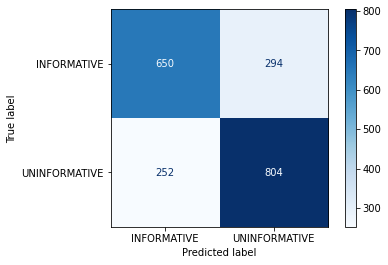

In [12]:
# This pipeline use TF-IDF as Vectorizer (Unigram) Passive Agressive Classifier as the main classifier
pac_pipeline = Pipeline([
    ("cln", Cleaner()),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7)),
    ('pac', PassiveAggressiveClassifier(max_iter=50))
])
pac_pipeline.fit(x_train, y_train)
pac_pred = pac_pipeline.predict(x_test)
pac_score = accuracy_score(y_test, pac_pred)

# Print the accuracy metrics
print(f'Accuracy: {round(pac_score*100,2)}%')
plot_confusion_matrix(pac_pipeline, x_test, y_test, cmap = "Blues")

## Vectorize Using Bigram and Unigram

Accuracy: 76.15%


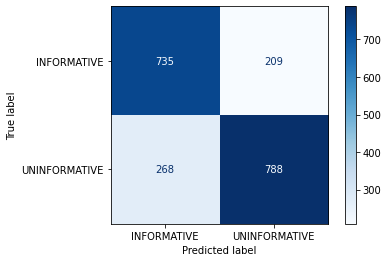

In [13]:
# This pipeline use TF-IDF as Vectorizer (Unigram and Bigram) Passive Agressive Classifier as the main classifier
pac_pipeline = Pipeline([
    ('cln', Cleaner()),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7, ngram_range=(1, 2))),
    ('pac', PassiveAggressiveClassifier(max_iter=50))
])
pac_pipeline.fit(x_train, y_train)
pac_pred = pac_pipeline.predict(x_test)
pac_score = accuracy_score(y_test, pac_pred)

# Print the accuracy metrics
print(f'Accuracy: {round(pac_score*100,2)}%')
plot_confusion_matrix(pac_pipeline, x_test, y_test, cmap = "Blues")

## Vectorize Using Bigram

Accuracy: 72.15%


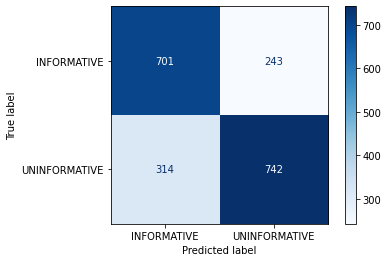

In [14]:
# This pipeline use TF-IDF as Vectorizer (Bigram only) Passive Agressive Classifier as the main classifier
pac_pipeline = Pipeline([
    ('cln', Cleaner()),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7, ngram_range=(2, 2))),
    ('pac', PassiveAggressiveClassifier(max_iter=50))
])
pac_pipeline.fit(x_train, y_train)
pac_pred = pac_pipeline.predict(x_test)
pac_score = accuracy_score(y_test, pac_pred)

# Print the accuracy metrics
print(f'Accuracy: {round(pac_score*100,2)}%')
plot_confusion_matrix(pac_pipeline, x_test, y_test, cmap = "Blues")

# Prediction Using Logistic Regression

## Vectorize Using Unigram

Accuracy: 74.8%


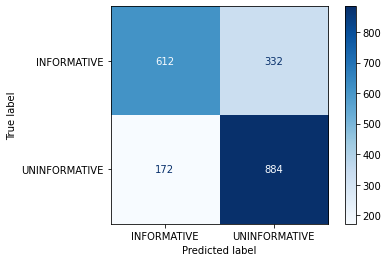

In [15]:
# This pipeline use Logistic Regression as the main classifier
lr_pipeline = Pipeline([
    ('cln', Cleaner()),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7)),
    ('lr', LogisticRegression())
])
lr_pipeline.fit(x_train, y_train)
lr_pred = lr_pipeline.predict(x_test)
lr_score = accuracy_score(y_test, lr_pred)

# Print the accuracy metrics
print(f'Accuracy: {round(lr_score*100,2)}%')
plot_confusion_matrix(lr_pipeline, x_test, y_test, cmap="Blues")

## Vectorize Using Bigram and Unigram

Accuracy: 74.3%


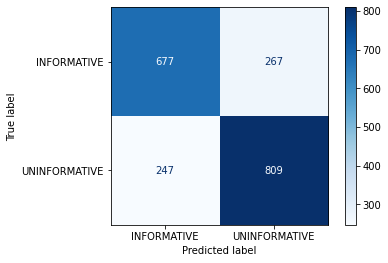

In [16]:
# This pipeline use use TF-IDF as Vectorizer (Unigram and Bigram) Logistic Regression as the main classifier
lr_pipeline = Pipeline([
    ('cln', Cleaner()),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7, ngram_range=(1, 2))),
    ('lr', LogisticRegression())
])
lr_pipeline.fit(x_train, y_train)
lr_pred = lr_pipeline.predict(x_test)
lr_score = accuracy_score(y_test, lr_pred)

# Print the accuracy metrics
print(f'Accuracy: {round(lr_score*100,2)}%')
plot_confusion_matrix(lr_pipeline, x_test, y_test, cmap="Blues")

## Vectorize Using Bigram

Accuracy: 70.35%


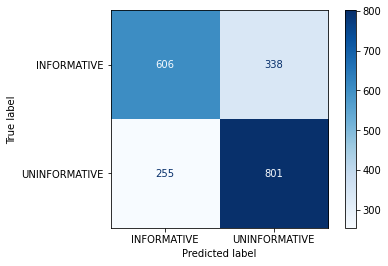

In [17]:
# This pipeline use use TF-IDF as Vectorizer (Bigram only) Logistic Regression as the main classifier
lr_pipeline = Pipeline([
    ('cln', Cleaner()),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7, ngram_range=(2, 2))),
    ('lr', LogisticRegression())
])
lr_pipeline.fit(x_train, y_train)
lr_pred = lr_pipeline.predict(x_test)
lr_score = accuracy_score(y_test, lr_pred)

# Print the accuracy metrics
print(f'Accuracy: {round(lr_score*100,2)}%')
plot_confusion_matrix(lr_pipeline, x_test, y_test, cmap="Blues")

## Using K-means As a Preprocessor

Accuracy: 63.55%


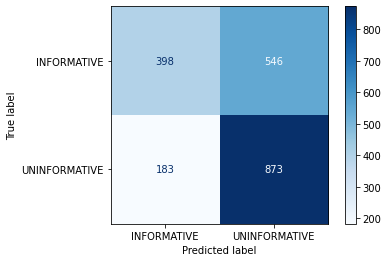

In [18]:
# This pipeline use K-means as a preprocessor before using Logistic Regression as a classifier
lrk_pipeline = Pipeline([
    ('cln', Cleaner()),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7)),
    ('kmeans', KMeans()),
    ('lr', LogisticRegression())
])
lrk_pipeline.fit(x_train, y_train)
lrk_pred = lrk_pipeline.predict(x_test)
lrk_score = accuracy_score(y_test, lrk_pred)

# Print the metrics
print(f'Accuracy: {round(lrk_score*100,2)}%')
plot_confusion_matrix(lrk_pipeline, x_test, y_test, cmap="Blues")

# Conclusion
We can see that the Passive Aggressive Classifier using Unigram and Bigram TF-IDF Vectorizer has the best performance at around 76%%. However, the performance of both Passive Aggressive Classifier and Logistic Regression does not improve much with the combination of unigram and bigram or bigram alone in comparison to unigram. Furthermore, Logistic Regression performs worse when the data is preprocessed by K-means. It is also clear that most of the inaccurate prediction of Logistic Regression is False Positive. Finally, 76% accuracy is not a good classifer.